In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from src.preprocess.VoiceBankDEMAND import VoiceBandDEMAND
from src.preprocess.feature_extractor import FeatureExtractor
from src.utils import read_audio, load_yaml
from src.distrib import load_model

# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib

# SHOULD PUT model path
model_path = Path(f'./history/221122-1127/data/20221123-183326')
path_conf = os.path.join(model_path, "config.yaml")
args = load_yaml(path_conf)
args.model.path = model_path.as_posix()

Found GPU at: /device:GPU:0Metal device set to: 
Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-28 18:18:18.327963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 18:18:18.328087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# 1. Load Paramter
device_lib.list_local_devices()
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

model_name = args.model.name
save_path = args.dset.save_path
flag_fft = args.dset.fft
nfft = args.dset.n_fft
hop_length = args.dset.hop_length
center = args.dset.center
num_features = args.model.n_feature
num_segments = args.model.n_segment
normalization = args.dset.normalize
fft_normalization = args.dset.fft_normalize
top_db = args.dset.top_db
train_split = int(args.dset.split*100)
sample_rate = args.dset.sample_rate
win_length = args.dset.win_length

2022-11-28 18:18:19.185310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 18:18:19.185330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# 3. Build and Load Model
model = load_model(args)

2022-11-28 18:18:19.266388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 18:18:19.266412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 2, 1, 64, 2  0           []                               
                                57)]                                                              
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 1, 64, 257)  0           ['input[0][0]']                  
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, 64, 257)     0           ['tf.__operators__.getitem[0][0]'
 da)                                                             ]                            

2022-11-28 18:18:22.036256: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 18:18:22.700883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 18:18:22.958218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 18:18:23.085844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 18:18:23.337527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 18:18:23.588861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.5156
Optimizer was loaded!


In [4]:

# Load audio file

dataset_path = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791"
dataset_voicebank = VoiceBandDEMAND(dataset_path, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = dataset_voicebank.get_test_filenames()
clean_file = clean_test_filenames[3] 
noisy_file = noisy_test_filenames[3]

clean_file = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_005.wav"
noisy_file = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_005.wav"

# clean_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav"
# noisy_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav"

print("Clean: ", clean_file)
print("Noisy: ", noisy_file)

clean_audio, sr = read_audio(clean_file, sample_rate)
noisy_audio, sr = read_audio(noisy_file, sample_rate)

mean = np.mean(noisy_audio)
std = np.std(noisy_audio)
noisy_audio_norm = (noisy_audio - mean) / std

clean_audio_feature_extractor = FeatureExtractor(clean_audio, windowLength=win_length, hop_length=hop_length, sample_rate=sr)
stft_features = clean_audio_feature_extractor.get_stft_spectrogram(center)
stft_features = np.abs(stft_features)

print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

noise_audio_feature_extractor = FeatureExtractor(noisy_audio_norm, windowLength=win_length, hop_length=hop_length, sample_rate=sr)
noise_stft_features = noise_audio_feature_extractor.get_stft_spectrogram(center)
noise_stft_features /= nfft

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisy_phase = np.angle(noise_stft_features)
noise_amplitude = np.abs(noise_stft_features)




File example:
Clean:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824
Clean:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_005.wav
Noisy:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_005.wav
Min: 5.406386449635647e-10 Max: 27.398282246534674


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
def _prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments
  

def revert_features_to_audio(features, phase, mean=None, std=None):
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    features *= nfft
    estimated_audio = noise_audio_feature_extractor.get_audio_from_stft_spectrogram(features, center)
    
    # scale the outpus back to the original range
    if mean and std:
        estimated_audio = std * estimated_audio + mean
    
    return estimated_audio


predictors_amp = _prepare_input_features(noise_amplitude, num_segments, num_features)
predictors_amp = np.reshape(predictors_amp, (predictors_amp.shape[0], predictors_amp.shape[1], predictors_amp.shape[2]))
predictors_amp = np.transpose(predictors_amp, (2, 0, 1)).astype(np.float32)
predictors_amp = np.transpose(predictors_amp, (0, 2, 1))

predictors_phase = _prepare_input_features(noisy_phase, num_segments, num_features)
predictors_phase = np.reshape(predictors_phase, (predictors_phase.shape[0], predictors_phase.shape[1], predictors_phase.shape[2]))
predictors_phase = np.transpose(predictors_phase, (2, 0, 1)).astype(np.float32)
predictors_phase = np.transpose(predictors_phase, (0, 2, 1))

predictors = np.stack([predictors_amp, predictors_phase], axis=1)
predictors = np.expand_dims(predictors, axis=2)

estimation_stft = model.predict(predictors)
estimation_stft = estimation_stft[..., -1, :]
estimation_stft = np.squeeze(estimation_stft)

# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

if model_name == 'lstm':
    estimation = revert_features_to_audio(estimation_stft[:, 0, :], estimation_stft[:, 1, :], mean, std)

print("Min:", np.min(estimation),"Max:",np.max(estimation))
# ipd.Audio(data=estimation, rate=fs) # load a local WAV file

print(estimation.shape)

2022-11-28 18:18:24.582464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 18:18:24.701092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/13 [=>............................] - ETA: 7s

2022-11-28 18:18:24.838797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 42ms/step
Min: -0.5340567 Max: 0.42722604
(99840,)


Text(0.5, 1.0, 'Denoised Audio')

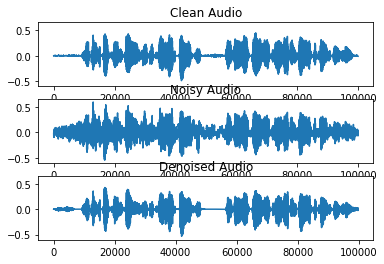

In [7]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(clean_audio)
ax1.set_title("Clean Audio")

ax2.plot(noisy_audio)
ax2.set_title("Noisy Audio")

ax3.plot(estimation)
ax3.set_title("Denoised Audio")


In [8]:
import IPython.display as ipd

In [9]:
ipd.Audio(data=clean_audio, rate=sample_rate) # load a local WAV file

In [10]:
ipd.Audio(data=noisy_audio, rate=sample_rate) # load a local WAV file

In [11]:
ipd.Audio(data=estimation, rate=sample_rate) # load a local WAV file

In [12]:
import numpy as np
import librosa
import librosa.display

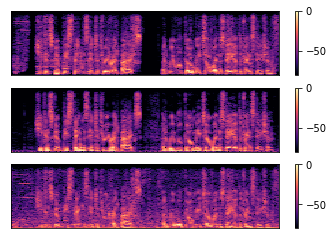

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(estimation, fig, ax0)
show_stft(clean_audio, fig, ax1)
show_stft(noisy_audio, fig, ax2)

In [14]:
# bose_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/proc.wav"
# boseAudio, sr = read_audio(bose_file, sample_rate)
# ipd.Audio(data=boseAudio, rate=sample_rate)